<h1>Creating Fig. 6 of Siegert et al. (2020)</h1>

<h3>Imports for plotting and arary manipulation</h3>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
plt.style.use('thomas')

/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
plt.style.use('thomas')

<h3>Load response part of COSIpy</h3>

In [3]:
import response

Welcome to JupyROOT 6.14/08


<h3>Read in MEGAlib-generated 511 keV response (start from scratch)</h3>

In [4]:
test = response.SkyResponse(
    'response/511Response_cori_v1_nuclearizer_v8_9Det_imaging_atmos_5deg_v1.binnedimaging.imagingresponse.rsp.gz',
    pixel_size=5,from_saved_file=False)

In [5]:
test.ReadMEGAlibResponse()

<h3>Response dimensions:<br>
    1650: 2D zenith/azimuth sky angles (2D->1D FISBEL)<br>
    36:   Compton scattering angle<br>
    1650: 1D psi/chi scattering dimension (2D->1D FISBEL)</h3>

In [6]:
test.rsp.response.shape

(1650, 36, 1650)

<h3>Re-grid FISBEL sky dimension to regular 2D grid (mainly for matrix and array arithmetic at a later stage)</h3>

In [7]:
test.RebinToSquarePixelGrid()

Now calculating mapping function ...



Applying mapping function to all response entries, 36 phi bins times 1650 FISBEL bins, i.e. 59400 bins in total ...



Binned sky response contains 5715 (9.621212121212121%) non-zero entries: use reduced data space to save fit in fits!


<h3>i.e. Mapping from 1650-element 1D-array to (36x72)-element 2D-array</h3>

In [8]:
test.rsp.mapping_function.shape

(1650, 36, 72)

<h3>New response array:<br>
    36:   1D zenith sky angles<br>
    72:   1D azimuth sky angles<br>
    36:   Compton scattering angle<br>
    1650: 1D psi/chi scattering dimension (2D->1D FISBEL)</h3>

In [9]:
test.rsp.response_grid_normed.shape

(36, 72, 36, 1650)

<h3>Example plot:</h3>

Text(0, 0.5, 'zenith [rad]')

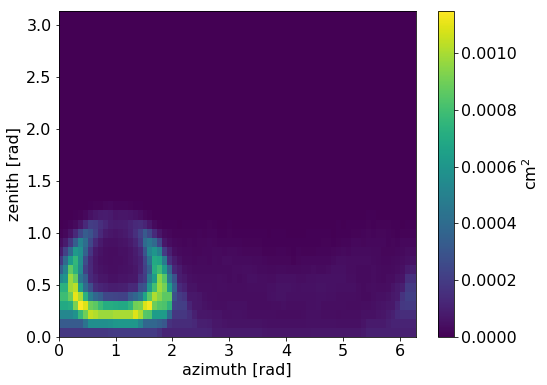

In [10]:
plt.pcolormesh(test.l_edges,test.b_edges,test.rsp.response_grid_normed[:,:,5,180])
plt.colorbar(label=r'$\mathrm{cm^2}$')
plt.xlabel('azimuth [rad]')
plt.ylabel('zenith [rad]')

<h3>Inside the routines:</h3>

In [11]:
###################################
### normalisation as in MEGAlib ###
###################################
# self.CDS_norm = self.regular_pixel_area*
#               (self.total_simulated_counts/(4*np.pi))/self.simulation_start_area
# 
##########################################
### loop over all CDS response entries ###
##########################################
# for i in tqdm(range(self.rsp.phis.n_phi_bins)):
#     for j in range(self.rsp.fisbels.n_fisbel_bins):
#         # speed up the process and check wether 
#         # there are any photons in the entry i,j
#         if (np.sum(self.rsp.response[:,i,j]) > 0):
#             self.rsp.response_grid_normed[:,:,i,j] =
#             np.sum(self.rsp.mapping_function[:,:,:]*
#             (self.rsp.response[:,i,j])[:,None,None],axis=0)/self.CDS_norm

<h3>This means, the entries <em>are</em> normalised to their pixel size already and the unit of each entry is $\mathrm{cm^2}$!</h3>

<h3>Cross check for solid angle (pixel) normalisations:</h3>

In [12]:
np.sum(test.fisbel_area),4*np.pi

(12.566369999999623, 12.566370614359172)

In [13]:
np.sum(test.regular_pixel_area),4*np.pi

(12.566370614359172, 12.566370614359172)

<h3>And for arbitrary entry in response before and after re-gridding:</h3>

In [14]:
# before
np.sum(test.rsp.response[:,5,180]/(test.total_simulated_counts/(4*np.pi))*\
       test.simulation_start_area)

0.00044081285131744135

In [15]:
# after
np.sum(test.rsp.response_grid_normed[:,:,5,180]*test.regular_pixel_area)

0.0004408128513174414

<h3>Comparison pixel areas over sky:</h3>

Text(0, 0.5, 'Zenith [rad]')

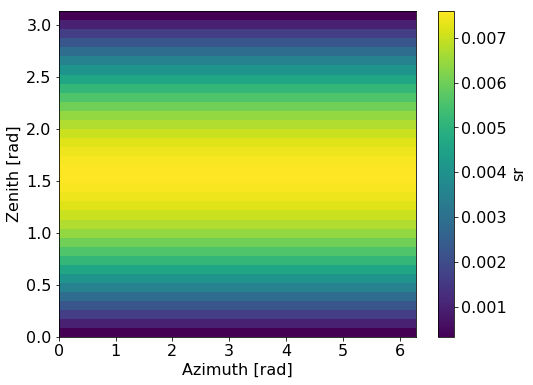

In [16]:
plt.figure(figsize=(8,6))
plt.pcolormesh(test.L_ARR_edges,test.B_ARR_edges,test.regular_pixel_area)
plt.colorbar(label='sr')
plt.xlabel('Azimuth [rad]')
plt.ylabel('Zenith [rad]')

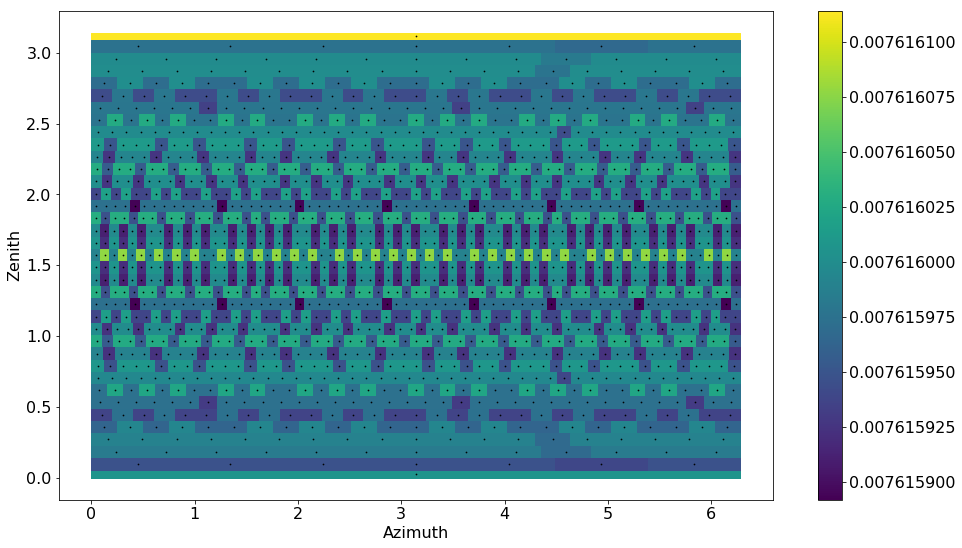

In [17]:
test.rsp.fisbels.plot_FISBEL_tessellation(tiles=True,
                                          values=np.array(test.fisbel_area),
                                          colorbar=True)

<h3>Size of response in RAM:</h3>

In [18]:
# GB
(test.rsp.response_grid_normed.size * test.rsp.response_grid_normed.itemsize)/1024**3

1.1471271514892578

<h3>Now plot:</h3>

In [19]:
test.rsp.response_grid_normed.shape

(36, 72, 36, 1650)

In [20]:
np.rad2deg(test.rsp.phis.phi_edges[3:5])

array([15., 20.])

<h3>Polar coordinate grid:</h3>

In [21]:
b3 = np.linspace(0,np.pi,36)
l3 = np.linspace(0,2*np.pi,72)
L3, B3 = np.meshgrid(l3,b3)
b3g = np.linspace(0,np.pi,37)
l3g = np.linspace(0,2*np.pi,73)
L3g, B3g = np.meshgrid(l3g,b3g)

Text(0.5, 1.05, '$\\phi = [15,20]\\,\\mathrm{deg}$; $(\\psi,\\chi) = $ some combination')

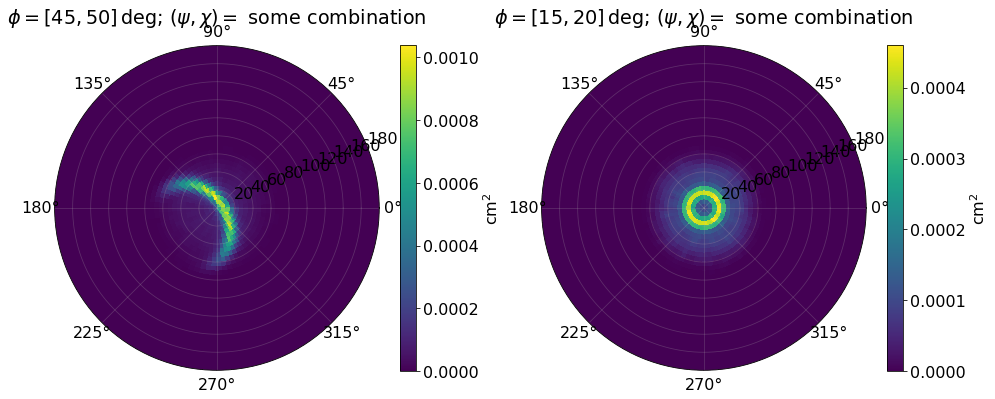

In [22]:
plt.figure(figsize=(16,6))
plt.subplot(121,projection='polar')
im = plt.pcolormesh(L3g,np.rad2deg(B3g),test.rsp.response_grid_normed[:,:,9,200])
plt.grid(True,alpha=0.25)
plt.colorbar(label=r'$\mathrm{cm^2}$')
plt.ylim(0,180)
plt.title(r'$\phi = [45,50]\,\mathrm{deg}$; $(\psi,\chi) = $ some combination')

plt.subplot(122,projection='polar')
im = plt.pcolormesh(L3g,np.rad2deg(B3g),test.rsp.response_grid_normed[:,:,3,0])
plt.grid(True,alpha=0.25)
plt.colorbar(label=r'$\mathrm{cm^2}$')
plt.ylim(0,180)
plt.title(r'$\phi = [15,20]\,\mathrm{deg}$; $(\psi,\chi) = $ some combination')

<h3>Circles (cones) as expected</h3>

<h3>Summing over all CDS angles (dimensions 2 and 3 of response):</h3>

In [23]:
test.rsp.response_grid_normed.shape

(36, 72, 36, 1650)

<h3>Here, I normalise by the pixel dimensions of the CDS so that I can find the effective arera per sky pixel size below (maybe something wrong here?):</h3>

In [24]:
rsp_zenazi = np.sum(test.rsp.response_grid_normed/\
                    ((2*np.pi/36)*\
                     np.array(test.fisbel_area)[None,None,None,:]),
                    axis=(2,3))

In [25]:
rsp_zenazi.shape

(36, 72)

<h3>Grid for the sky:</h3>

In [26]:
n_zen = 36
n_azi = 72
thetag = np.linspace(0,180,n_zen+1)
theta = thetag[0:-1]+180/(n_zen*2)
phig = np.linspace(-180,180,n_azi+1)
phi = phig[0:-1]+360/(n_azi*2)
THETAg,PHIg = np.meshgrid(thetag,phig)
THETA,PHI = np.meshgrid(theta,phi)

<h3>Effective area polar plot:</h3>

(0, 90)

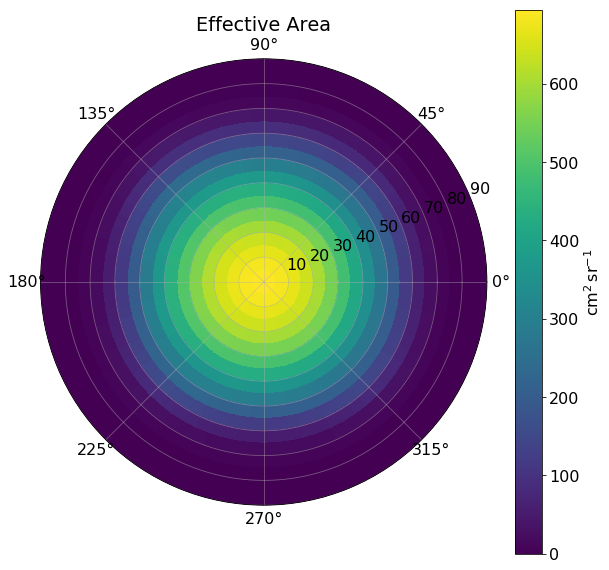

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(projection='polar')
plt.pcolormesh(np.deg2rad(PHIg),THETAg,rsp_zenazi.T)
plt.grid(True,alpha=0.5)
plt.colorbar(label=r'$\mathrm{cm^2\,sr^{-1}}$')
plt.title('Effective Area')
plt.ylim(0,90)

In [28]:
# we defined our sky-grid on a regular 5x5 pixel grid, so that the solid angle element is domega
binsize = 5
domega = np.abs(((binsize*np.pi/180)*(np.sin(np.deg2rad(THETA+binsize/2)) -\
                                      np.sin(np.deg2rad(THETA-binsize/2)))).T)
# note zenith/azimuth convention, 
# not longituded/latitude (zenith and nadir get large values)

In [29]:
np.sum(domega),4*np.pi

(12.566370614359172, 12.566370614359172)

<h3>And finally averaging (this time with the correct integration elements):</h3>

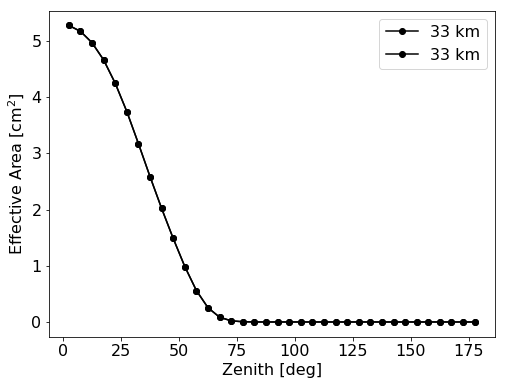

In [40]:
plt.plot(theta,np.mean(rsp_zenazi[:,:]*domega,axis=1),'ko-',label='33 km')
plt.plot(theta,np.sum(rsp_zenazi[:,:]*domega,axis=1)*(2*np.pi/36)/4/np.pi,'ko-',label='33 km')
plt.xlabel('Zenith [deg]')
plt.ylabel(r'Effective Area [$\mathrm{cm^2}$]')
plt.legend()

<h3>And taking the atmospheric transmissivities into account:</h3>

<h3>Quick read in of MEGAlib-compatible file Absorber dat with pandas:</h3>

In [31]:
absorb_df = pd.read_csv('/Users/thomassiegert/data/COSI/Absorber.dat',
                        sep=' ',skiprows=8)
energies = absorb_df['80.0']
thetas = absorb_df['60.0']
heights = absorb_df['50.0']
Tprob = absorb_df['100.0']
idx = np.where(energies == 500)[0]

<h3>Re-scaling of transmissiioni probabilities to have 33 km == 1:</h3>

In [32]:
Tprob_arr = np.zeros((16,19))
for i in range(19):
    Tprob_arr[:,i] = Tprob[idx[i::19]]/\
    Tprob[idx[i::19]].values[np.where(heights[idx[i::19]] == 33000)[0]]

In [33]:
h_arr = heights[idx[0::19]].values
z_arr = thetas[idx[0:19]].values

<h3>Altitude re-normalisation grid:</h3>

Text(0.5, 0, 'Zenith angle [deg]')

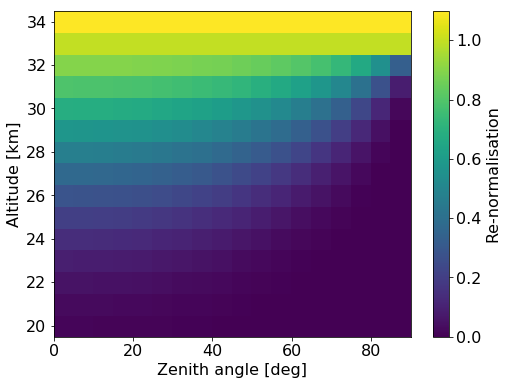

In [34]:
plt.pcolormesh(z_arr,h_arr/1e3-0.5,Tprob_arr,vmin=0,vmax=1.1)
plt.colorbar(label='Re-normalisation')#orientation='horizontal')
plt.ylabel('Altitude [km]')
plt.xlabel('Zenith angle [deg]')

<h3>And final plot:</h3>

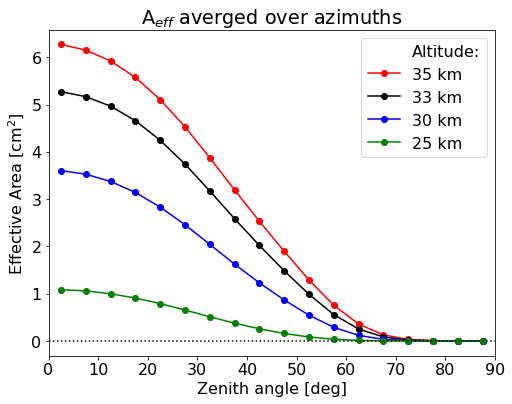

In [35]:
plt.plot(-10,0,color='white',marker='o',label='Altitude:')
plt.plot(theta[0:18],np.mean(rsp_zenazi[0:18,:]*domega[0:18,:]*\
                             Tprob_arr[15,0:18][:,None],axis=1),
         'ro-',label='35 km')
plt.plot(theta[0:18],np.mean(rsp_zenazi[0:18,:]*domega[0:18,:],axis=1),
         'ko-',label='33 km')
plt.plot(theta[0:18],np.mean(rsp_zenazi[0:18,:]*domega[0:18,:]*\
                             Tprob_arr[10,0:18][:,None],axis=1),
         'bo-',label='30 km')
plt.plot(theta[0:18],np.mean(rsp_zenazi[0:18,:]*domega[0:18,:]*\
                             Tprob_arr[5,0:18][:,None],axis=1),
         'go-',label='25 km')
plt.axhline(0,linestyle=':')
plt.ylabel('Effective Area [cm$^2$]')
plt.xlabel('Zenith angle [deg]')
plt.title('A$_{eff}$ averged over azimuths')
plt.xlim(0,90)
#plt.ylim(-0.05,1.175)
plt.legend();
plt.savefig('Effective_Area_Azimuth_Averaged_Altitudes_511keV_erratum.pdf')

In [46]:
np.arange(7)

array([0, 1, 2, 3, 4, 5, 6])